# A simple MNIST classifier

In this little notebook we will train neural networks on the MNIST dataset. We begin with a simple fully connected network and briefly do error analysis on this network. Afterwards, we add a convolutional layer to the network to see if this improves the overall model performance (which it does, as will turn out). Starting from there, we investigate the effect of adding dropout layers, performing batch normalization and using several convolutional layers to the model performance. For some of these models we continue the short error analysis. and point at ways to improve the networks though we do not go in these direction at all.

We begin by loading the basic libraries and modules we are going to use. If you wish to train your model on an AMD graphics card, you may want to have a look at plaidml and change the first cell accordingly. Also if you don't want to use tensorboard feel free to delete the respective lines of code. We provided functions for plotting the accurarcy and loss during training below and they are also used in addition to tensorboard.

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import numpy as np
import pandas as pd

from IPython.display import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from keras.utils import to_categorical

keras.backend.set_image_data_format('channels_last')

%load_ext tensorboard

Using TensorFlow backend.


In [2]:
def one_hot_to_label(pred):
    return np.argmax(pred)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Now, let us load the MNIST dataset. Luckily, it is part of the keras datasets so we can just load it with a simple command.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print('Number of training samples: ', x_train.shape[0])
print('Number of test samples: ', x_test.shape[0])

Number of training samples:  60000
Number of test samples:  10000


After loading the dataset, let us have a look at the data we have.

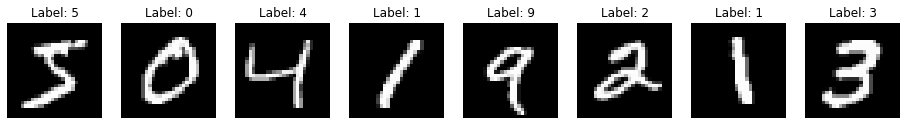

In [4]:
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for ind, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(x_train[ind], cmap=plt.get_cmap('gray'))
    ax.set_title('Label: ' + str(y_train[ind]))

Ok, so these are pictures of handwritten images, each 28x28 pixels and with greyscale values.

## Data preprocessing

There isn't much data preprocessing necessary for this dataset. But converting the pixel values to numbers between 0 and 1 is definitely something we can do easily and which speeds up training quite a bit. So let us do so.

In [5]:
def preprocess_data(x, y):
    x = x.astype('float32')
    x = x.reshape((x.shape[0], 28, 28, 1)) # add extra dimension to use conv2d in the model
    x = x/255 # normalize to values between 0 and 1
    
    y = to_categorical(y) # one hot encoding
    return x, y
    

In [6]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

## Fully connected model

Let us start by defining a fully connected network as first model. We take the input image (28x28x1), flatten it into a fully connected layer of size 28\*28=784 and then reduce its size by a factor of four in each step.

In [7]:
def fully_connected_model(input_shape, name='MNIST_fully_connected'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Flatten()(X) # fully connected layer with 784 nodes
    
    # reduce by factor of four in each layer
    X = Dense(512, activation='relu')(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)

    model = Model(X_input, X, name=name)
    
    return model
    
fully_connected_model = fully_connected_model((28, 28, 1))
print(fully_connected_model.summary())

Model: "MNIST_fully_connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 472,042
Trainable params: 472,042
Non-trainable params: 0
_______________________________________

Alright, so we have 472,042 parameters and four hidden layers. Let's see how well our model performs after some training!

## Training and Evaluation

In [8]:
fully_connected_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
%tensorboard --logdir ./logs/fully_connected_model/
history = fully_connected_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True, 
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/fully_connected_model/')])
score = fully_connected_model.evaluate(x_test, y_test)

fully_connected_model.save_weights('./models/fully_connected_model.h5')

Reusing TensorBoard on port 6013 (pid 5720), started 18:09:33 ago. (Use '!kill 5720' to kill it.)

Epoch 1/15
  1/394 [..............................] - ETA: 0s - loss: 2.3370 - accuracy: 0.1562WARNING:tensorflow:From /Users/heckel/opt/anaconda3/envs/MNIST/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
394/394 [==============================] - 2s 4ms/step - loss: 0.2902 - accuracy: 0.9141 - val_loss: 0.1320 - val_accuracy: 0.9648
Epoch 2/15
394/394 [==============================] - 1s 4ms/step - loss: 0.1003 - accuracy: 0.9700 - val_loss: 0.1063 - val_accuracy: 0.9685
Epoch 3/15
394/394 [==============================] - 1s 4ms/step - loss: 0.0648 - accuracy: 0.9804 - val_loss: 0.0837 - val_accuracy: 0.9753
Epoch 4/15
394/394 [==============================] - 2s 4ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.0819 - val_accuracy: 0.9760
Epoch 5/15
394/394 [======================

So how does our model perform? Let's have a look at the graphs and scores (if you are using tensorboard, you have seen the graphs already).

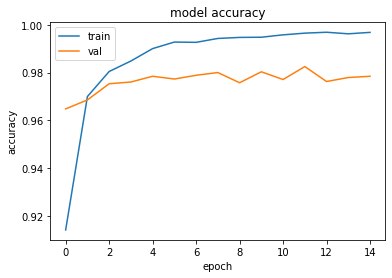

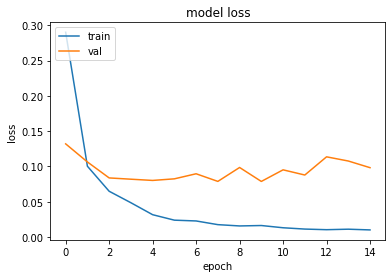

In [10]:
plot_accuracy(history)
plot_loss(history)

In [11]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Accuracy on train set:  0.9968055486679077
Accuracy on test set:  0.9772999882698059


We have 97.7% accuracy on the test set which seems to be reasonable good for a quick test run and a model as simple as ours. On the train set we achieve 99.6% accuracy which is way more -- our model is overfitting the train set!

To perform some brief error analysis, we begin by looking at some of the false predictions of the model.

Number of wrong predictions:  227


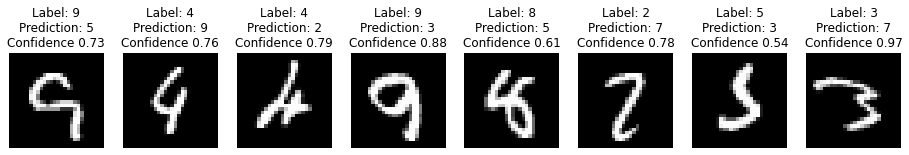

In [12]:
def plot_incorrect_preds(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    incorrect = np.where(pred_labels != true_labels)[0]
    print('Number of wrong predictions: ', len(incorrect))
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for ind, ax in enumerate(axes.flat):
        ind = incorrect[ind]
        ax.set_axis_off()
        ax.imshow(x_test[ind], cmap=plt.get_cmap('gray'))
        true_label = one_hot_to_label(y_test[ind])
        predicted_label = one_hot_to_label(pred[ind])
        confidence = pred[ind, predicted_label]
        ax.set_title('Label: %s\nPrediction: %s\nConfidence %1.2f' %(true_label, predicted_label, confidence))
        
plot_incorrect_preds(fully_connected_model)

This shows 227 false predictions in total but it is hard to investigate systematic errors just by looking at (few) examples. Thus, let us plot predictions versus ground truth and inicate the number of samples at a point (truth, prediction) by its color itensity.

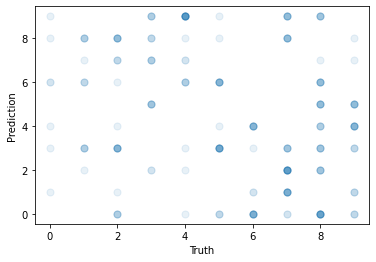

In [13]:
def plot_preds_scatter(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    
    df = pd.DataFrame(true_labels, columns=['Truth'])
    df['Prediction'] = pred_labels
    df['Incorrect'] = np.where(df['Truth'] == df['Prediction'], False, True)
    df_incorr = df.loc[df.Incorrect].reset_index(drop=True)
    
    df_incorr.plot(x='Truth', y='Prediction', kind='scatter', alpha=.1, s=50, title='')
    
plot_preds_scatter(fully_connected_model)

This reveals, for example, that a four is often mistaken for a nine by the model, six and eight for a zero, seven for one and two and so on. We also see that what is predicted four should often times be a nine, thus distinguishing four from nine seems to be hard for the model. We may also have a look at how often number are predicted incorrectly and how many incorrect predictions are there per number.

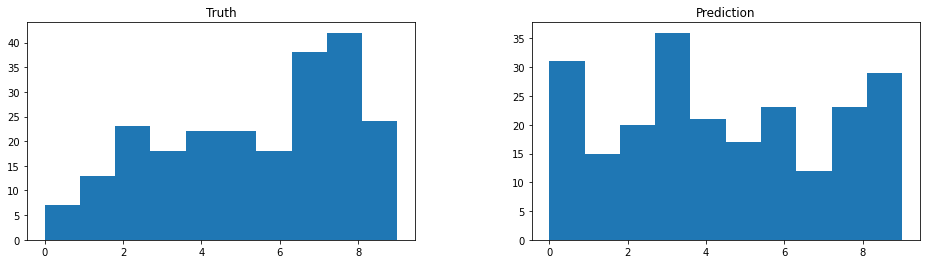

In [14]:
def plot_incorr_preds_hist(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    
    df = pd.DataFrame(true_labels, columns=['Truth'])
    df['Prediction'] = pred_labels
    df['Incorrect'] = np.where(df['Truth'] == df['Prediction'], False, True)
    df_incorr = df.loc[df.Incorrect].reset_index(drop=True)
    
    df_incorr.hist(column=['Truth', 'Prediction'], figsize=(16, 4), grid=False)

plot_incorr_preds_hist(fully_connected_model)

The numbers seven and eight seem to cause most of the mispredictions. Moreover, if a three is predicted, the model is wrong more often than for other numbers. But also predictions for zero and nine are often inaccurate. This goes in line with what we saw from the scatter plot above but in total, our error analysis so far doesn't really give deep insights.

## A convolutional model

For computer vision tasks (as recognizing digits in images) convolutional networks usually perform better as it is possible for them to learn patterns. So let us set up a new model with one convolutional layer followed by dense layers, reducing the the size by four in each step, just as before.

In [15]:
def conv_model(input_shape, name='Convolutional_MNIST_model'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(32, (4, 4), strides=2)(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model = conv_model((28, 28, 1))
print(conv_model.summary())

Model: "Convolutional_MNIST_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1606656   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 64)  

Now let's train this model.

In [16]:
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%tensorboard --logdir ./logs/conv_model/
    
history = conv_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True,
                               callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model/')])
score = conv_model.evaluate(x_test, y_test)

conv_model.save_weights('./models/conv_model.h5')

Reusing TensorBoard on port 6011 (pid 5031), started 20:00:18 ago. (Use '!kill 5031' to kill it.)

Epoch 1/15
394/394 [==============================] - 8s 21ms/step - loss: 0.2254 - accuracy: 0.9303 - val_loss: 0.0749 - val_accuracy: 0.9780
Epoch 2/15
394/394 [==============================] - 8s 20ms/step - loss: 0.0634 - accuracy: 0.9808 - val_loss: 0.0793 - val_accuracy: 0.9758
Epoch 3/15
394/394 [==============================] - 8s 20ms/step - loss: 0.0376 - accuracy: 0.9887 - val_loss: 0.0558 - val_accuracy: 0.9842
Epoch 4/15
394/394 [==============================] - 8s 21ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 0.0531 - val_accuracy: 0.9852
Epoch 5/15
394/394 [==============================] - 9s 23ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0572 - val_accuracy: 0.9854
Epoch 6/15
394/394 [==============================] - 8s 21ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0634 - val_accuracy: 0.9839
Epoch 7/15
394/394 [==============================] - 8s 21ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0689 - val_accuracy: 0.9830

In [18]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Accuracy on train set:  0.9992262125015259
Accuracy on test set:  0.9829999804496765


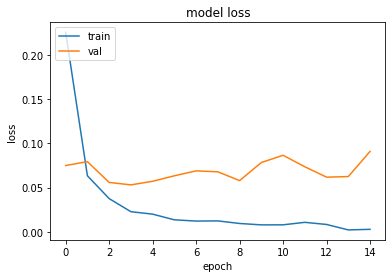

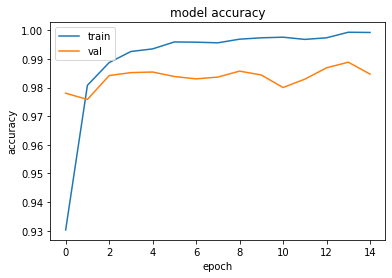

In [19]:
plot_loss(history)
plot_accuracy(history)

The convolutional model performs better on the test set but also clearly overfits the train set. One possibility to reduce overfitting that usually works is to add dropout layers so we'll now investigate their effect on the model performance.

### Adding dropout layers

The following model is basically the same as before but containing three dropout layers. 

In [20]:
def conv_model_with_dropout(input_shape, name='Convolutional_MNIST_model_with_dropout'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(32, (4, 4), strides=2, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Dropout(0.4)(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model_with_dropout = conv_model_with_dropout((28, 28, 1))
print(conv_model_with_dropout.summary())

Model: "Convolutional_MNIST_model_with_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1606656   
_________________________________________________________________
dropout_1 (Dropout)         

In [21]:
conv_model_with_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/conv_model_with_dropout/
    
history = conv_model_with_dropout.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.16, 
                                      shuffle=True,
                                      callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model_with_dropout/')])
score = conv_model_with_dropout.evaluate(x_test, y_test)

conv_model_with_dropout.save_weights('./models/conv_model_with_dropout.h5')

Reusing TensorBoard on port 6012 (pid 5103), started 19:54:45 ago. (Use '!kill 5103' to kill it.)

Epoch 1/10
394/394 [==============================] - 11s 27ms/step - loss: 0.3441 - accuracy: 0.8924 - val_loss: 0.0937 - val_accuracy: 0.9715
Epoch 2/10
394/394 [==============================] - 10s 25ms/step - loss: 0.1248 - accuracy: 0.9612 - val_loss: 0.0613 - val_accuracy: 0.9811
Epoch 3/10
394/394 [==============================] - 10s 25ms/step - loss: 0.0915 - accuracy: 0.9728 - val_loss: 0.0491 - val_accuracy: 0.9845
Epoch 4/10
394/394 [==============================] - 10s 25ms/step - loss: 0.0714 - accuracy: 0.9781 - val_loss: 0.0494 - val_accuracy: 0.9856
Epoch 5/10
394/394 [==============================] - 10s 24ms/step - loss: 0.0636 - accuracy: 0.9806 - val_loss: 0.0402 - val_accuracy: 0.9880
Epoch 6/10
394/394 [==============================] - 10s 24ms/step - loss: 0.0535 - accuracy: 0.9831 - val_loss: 0.0427 - val_accuracy: 0.9886
Epoch 7/10
394/394 [==============================] - 10s 24ms/step - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.0414 - val_accuracy:

In [22]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Accuracy on train set:  0.9876587390899658
Accuracy on test set:  0.9886999726295471


Our model is now doing equally well on the train and test set so we can say that we successfully reduced (or even eliminated) the problem of overfitting the train set. We may look again at mislabelled examples and do our short error analysis as we did for the fully connected model.

Number of wrong predictions:  113


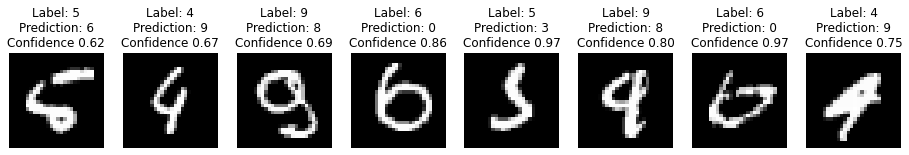

In [23]:
plot_incorrect_preds(conv_model_with_dropout)

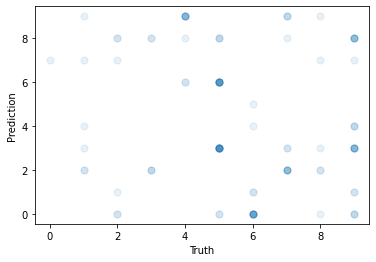

In [24]:
plot_preds_scatter(conv_model_with_dropout)

Again, a four is often mistaken to be a nine. The number five seems to be mistaken for three and six relatively often and also there still is the problem that seix is confused with zero by the model. Let us look at the histograms again.

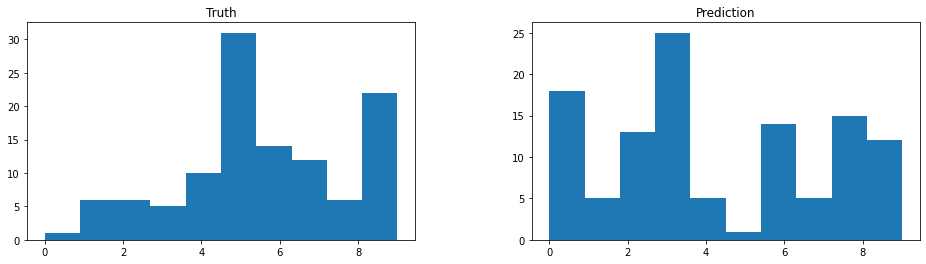

In [25]:
plot_incorr_preds_hist(conv_model_with_dropout)

They definitely confirm what we expected from the scatter plot. Five and nine are causing most of the errors. To improve the model, it will most likely be helpful to add more images of five and nine to the dataset, for exampe by augmenting the existing data. But instead of doing so, we will try improve the performance by adding batch normalization to our model.

## Adding batch normalization

In [26]:
def conv_model_dropout_batchnorm(input_shape, name='Convolutional_MNIST_model_with_dropout_and_batch_normalization'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = BatchNormalization()(X)
    X = Conv2D(32, (4, 4), strides=2, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Dropout(0.4)(X)
    
    X = BatchNormalization()(X)
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model_dropout_batchnorm = conv_model_dropout_batchnorm((28, 28, 1))
print(conv_model_dropout_batchnorm.summary())

Model: "Convolutional_MNIST_model_with_dropout_and_batch_normalization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flat

In [27]:
conv_model_dropout_batchnorm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/conv_model_dropout_batchnorm/
    
history = conv_model_dropout_batchnorm.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, 
                                          shuffle=True,
                                          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model_dropout_batchnorm/')])
score = conv_model_dropout_batchnorm.evaluate(x_test, y_test)

conv_model_dropout_batchnorm.save_weights('./models/conv_model_with_dropout_and_batchnorm.h5')

Reusing TensorBoard on port 6014 (pid 5806), started 18:09:34 ago. (Use '!kill 5806' to kill it.)

Epoch 1/15
394/394 [==============================] - 15s 38ms/step - loss: 0.2977 - accuracy: 0.9090 - val_loss: 0.1389 - val_accuracy: 0.9672
Epoch 2/15
394/394 [==============================] - 15s 37ms/step - loss: 0.1215 - accuracy: 0.9624 - val_loss: 0.0562 - val_accuracy: 0.9836
Epoch 3/15
394/394 [==============================] - 15s 37ms/step - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.0494 - val_accuracy: 0.9865
Epoch 4/15
394/394 [==============================] - 15s 37ms/step - loss: 0.0761 - accuracy: 0.9765 - val_loss: 0.0549 - val_accuracy: 0.9820
Epoch 5/15
394/394 [==============================] - 15s 37ms/step - loss: 0.0668 - accuracy: 0.9794 - val_loss: 0.0437 - val_accuracy: 0.9873
Epoch 6/15
394/394 [==============================] - 14s 37ms/step - loss: 0.0576 - accuracy: 0.9814 - val_loss: 0.0416 - val_accuracy: 0.9873
Epoch 7/15
394/394 [==============================] - 15s 38ms/step - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.0504 - val_accuracy:

In [28]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Accuracy on train set:  0.9904166460037231
Accuracy on test set:  0.9900000095367432


We improved from 98.8% to 99% percent accuracy which isn't a big improvement but also batch normalization did no harm. So we decide to keep it.

## A deep convolutional network

As introducing a single convolutional layer worked out well, let us see how things are if we add many convolutional layer and try to learn the digit classification with a deep convolutional network. We will continue using dropout to prevent overfitting and batch normalization for (minor) performance improvement.

In [35]:
def deep_conv_model(input_shape, name='Deep_convolutional_MNIST_model'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = BatchNormalization()(X)
    X = Conv2D(8, (4, 4), activation='relu', padding='same')(X)
    X = Conv2D(8, (1, 1), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Conv2D(16, (4, 4), activation='relu', padding='same')(X)
    X = Conv2D(16, (1, 1), activation='relu')(X)
    X = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(X)
    X = Conv2D(32, (1, 1), activation='relu')(X)
    X = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(X)
    X = Conv2D(64, (1, 1), activation='relu')(X)
    X = Dropout(0.4)(X)
    X = Conv2D(128, (4, 4), strides=2, activation='relu')(X)
    X = Conv2D(128, (1, 1), activation='relu')(X)
    X = Dropout(0.4)(X)
    
    X = BatchNormalization()(X)
    X = Flatten()(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
deep_conv_model = deep_conv_model((28, 28, 1))
print(deep_conv_model.summary())

Model: "Deep_convolutional_MNIST_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 8)         136       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 8)         72        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 16)        2064      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 

Note that altough this is a deep model, it has much fewer parameters than our previous model.

In [36]:
deep_conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/deep_conv_model/
    
history = deep_conv_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True,
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/deep_conv_model/')])
score = deep_conv_model.evaluate(x_test, y_test)

deep_conv_model.save_weights('./models/deep_conv_model.h5')

Reusing TensorBoard on port 6010 (pid 2224), started 1 day, 0:04:08 ago. (Use '!kill 2224' to kill it.)

Epoch 1/15
394/394 [==============================] - 30s 77ms/step - loss: 0.6725 - accuracy: 0.7854 - val_loss: 0.1066 - val_accuracy: 0.9716
Epoch 2/15
394/394 [==============================] - 29s 73ms/step - loss: 0.1935 - accuracy: 0.9498 - val_loss: 0.1011 - val_accuracy: 0.9772
Epoch 3/15
394/394 [==============================] - 28s 70ms/step - loss: 0.1384 - accuracy: 0.9661 - val_loss: 0.0618 - val_accuracy: 0.9849
Epoch 4/15
394/394 [==============================] - 28s 70ms/step - loss: 0.1126 - accuracy: 0.9711 - val_loss: 0.0623 - val_accuracy: 0.9868
Epoch 5/15
394/394 [==============================] - 28s 71ms/step - loss: 0.0963 - accuracy: 0.9764 - val_loss: 0.0698 - val_accuracy: 0.9841
Epoch 6/15
394/394 [==============================] - 28s 70ms/step - loss: 0.0895 - accuracy: 0.9783 - val_loss: 0.0613 - val_accuracy: 0.9853
Epoch 7/15
394/394 [==============================] - 28s 71ms/step - loss: 0.0791 - accuracy: 0.9788 - val_loss: 0.0606 - val_accuracy:

In [37]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Accuracy on train set:  0.9884920716285706
Accuracy on test set:  0.989799976348877


This model performs similarly well as the model with only one convolutional layer, dropout and batch normalization.

Number of wrong predictions:  102


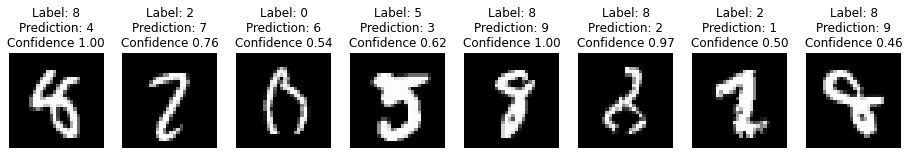

In [38]:
plot_incorrect_preds(deep_conv_model)

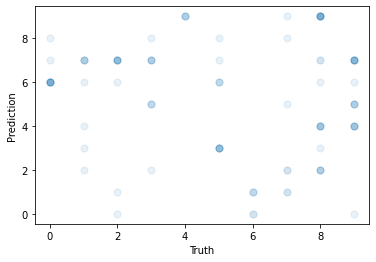

In [39]:
plot_preds_scatter(deep_conv_model)

Some of the wrong predictions seem a high confidence. The scatter plot reveals that a zero is often mistaken to be a six and that eight and nine get mispredicted much more often than other digits.

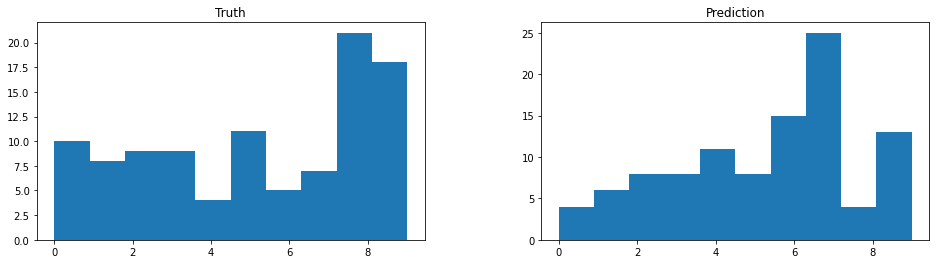

In [41]:
plot_incorr_preds_hist(deep_conv_model)

The histograms confirm this, 8 and nine are clearly causing more false predictions than other numbers.

As we mentioned before, this is not the end of the story but rather a starting point: as we have two models performing well (99% acuracy) on the MNIST dataset, we can try to fine-tune the models. For this, data augmentation seems to be a good starting point. There clearly are some digits that cause more problems than others so we should give the models more examples of these digits to learn and to improve.

But aside from this, reaching 99% on the MNIST dataset with only a little bit of training, no extensive data preprocessing and no fine-tuning is quite a good result in our opinion.